In [10]:
import numpy as np
from utils import *
import faiss
import random
import time
from tqdm import tqdm

In [2]:
sorted_hash_code_set = load_binary_file('sorted_hash_code_set.bin')

In [11]:
anno_files_list = get_all_anno_files(".")
anno_bit_vectors = load_all_annotation_bit_vectors(anno_files_list).T
print(anno_bit_vectors.shape) # [rows, cols]

(60801408, 32)


In [12]:
packed_anno_bit_vectors = np.packbits(anno_bit_vectors, axis=1)
packed_anno_bit_vectors = np.ascontiguousarray(packed_anno_bit_vectors)
print(packed_anno_bit_vectors.shape) # [rows, cols/8]

(60801408, 4)


In [39]:
d = 32
index = faiss.IndexBinaryFlat(d)
index.add(packed_anno_bit_vectors)
print("Number of vectors in the index:", index.ntotal)

Number of vectors in the index: 60801408


In [40]:
# Required memory for packed_anno_bit_vectors
print("Required memory for packed_anno_bit_vectors:", packed_anno_bit_vectors.nbytes)

Required memory for packed_anno_bit_vectors: 243205632


In [ ]:
def calculate_hamming_medoid(cluster):
    """
    Calculate the medoid of a cluster using Hamming distance.
    The medoid is the point in the cluster that minimizes the average Hamming distance to all other points.
    """
    if len(cluster) == 1:
        return cluster[0]  # A single point is its own medoid

    # Calculate pairwise Hamming distances within the cluster
    n_points = len(cluster)
    distances = np.zeros(n_points)
    for i, point in enumerate(cluster):
        # Hamming distance between this point and all others in the cluster
        distances[i] = sum(np.bitwise_xor(point, other).sum() for other in cluster)

    # Find the point with the smallest total distance
    medoid_index = np.argmin(distances)
    return cluster[medoid_index]

def hamming_distance(x, y):
    """
    Compute the Hamming distance between two packed binary vectors.
    The Hamming distance is calculated as the number of differing bits.
    """
    return np.bitwise_xor(x, y).sum()

def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on packed binary data using Hamming distance.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the packed dimensionality (e.g., 4 for 32-bit vectors).
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        clusters: List of clusters (each cluster is a list of packed binary vectors).
        medoids: List of medoids for each cluster.
    """
    # Step 1: Initialize each point as its own cluster
    clusters = [[point] for point in data]
    medoids = [point for point in data]  # Initially, each point is its own medoid
    
    print("Number of clusters:", len(clusters))
    print("Start clustering...")

    # Initialize tqdm progress bar
    with tqdm(total=len(clusters) - num_clusters, desc="Clustering Progress") as pbar:
        while len(clusters) > num_clusters:
            # Step 2: Randomly sample cluster pairs
            sampled_pairs = []
            for _ in range(sampling_size):
                c1, c2 = random.sample(range(len(clusters)), 2)  # Randomly pick two cluster indices
                sampled_pairs.append((c1, c2))

            # Step 3: Find the pair with the smallest Hamming distance (based on medoids)
            min_distance = float('inf')
            pair_to_merge = None
            for c1, c2 in sampled_pairs:
                # Calculate the Hamming distance between the medoids of the two clusters
                distance = hamming_distance(medoids[c1], medoids[c2])
                if distance < min_distance:
                    min_distance = distance
                    pair_to_merge = (c1, c2)

            # Step 4: Merge the selected pair of clusters
            c1, c2 = pair_to_merge
            merged_cluster = clusters[c1] + clusters[c2]

            # Update clusters
            clusters[c1] = merged_cluster
            clusters.pop(c2)  # Remove c2 cluster (merged into c1)

            # Step 5: Update the medoid for the merged cluster
            medoids[c1] = calculate_hamming_medoid(merged_cluster)
            medoids.pop(c2)  # Remove c2 medoid (merged into c1)

            # Update progress bar
            pbar.update(1)

    return clusters, medoids

# Example Usage
if __name__ == "__main__":
    # Example packed binary data: shape (20, 4) for 20 vectors (32 bits each packed into 4 uint8)
    np.random.seed(42)
    n_points = 200000
    n_bits = 32
    packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # Generate random binary data (32 bits per row) and pack it into uint8
    data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    packed_data = np.packbits(data, axis=1)  # Shape: (20, 4)

    # packed_data = packed_anno_bit_vectors
    
    # Perform clustering
    num_clusters = 1000
    clusters, medoids = greedy_agglomerative_clustering_hamming(packed_data, num_clusters, sampling_size=10)

    # Print results
    print(f"Number of clusters: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}: {len(cluster)} points, Medoid: {medoids[i].tolist()}")

Number of clusters: 200000
Start clustering...


Clustering Progress: 100%|██████████| 199000/199000 [07:40<00:00, 432.24it/s] 

Number of clusters: 1000
Cluster 1: 56 points, Medoid: [180, 118, 160, 243]
Cluster 2: 149 points, Medoid: [239, 179, 18, 54]
Cluster 3: 146 points, Medoid: [247, 0, 77, 102]
Cluster 4: 52 points, Medoid: [29, 123, 160, 244]
Cluster 5: 330 points, Medoid: [59, 249, 150, 67]
Cluster 6: 248 points, Medoid: [123, 243, 119, 45]
Cluster 7: 275 points, Medoid: [242, 153, 28, 68]
Cluster 8: 103 points, Medoid: [24, 134, 62, 95]
Cluster 9: 60 points, Medoid: [72, 112, 141, 204]
Cluster 10: 5 points, Medoid: [80, 183, 88, 27]
Cluster 11: 171 points, Medoid: [80, 111, 174, 48]
Cluster 12: 53 points, Medoid: [176, 253, 235, 87]
Cluster 13: 352 points, Medoid: [35, 29, 247, 232]
Cluster 14: 170 points, Medoid: [182, 67, 72, 105]
Cluster 15: 130 points, Medoid: [110, 149, 3, 26]
Cluster 16: 36 points, Medoid: [145, 220, 87, 221]
Cluster 17: 361 points, Medoid: [108, 127, 122, 24]
Cluster 18: 305 points, Medoid: [189, 153, 172, 84]
Cluster 19: 46 points, Medoid: [25, 158, 144, 218]
Cluster 20: 623 p

In [11]:
# Get average length of each cluster
cluster_sizes = [len(cluster) for cluster in clusters]
print("Average cluster size:", np.mean(cluster_sizes))


Average cluster size: 200.0


In [41]:
def hamming_distance_pair(a, b):
    """
    Compute the pairwise Hamming distance between two sets of bit-vectors.

    Parameters:
    a (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    b (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in a and b.
    """
    
    a = np.array(a)
    b = np.array(b)
    if a.shape != b.shape:
        raise ValueError("Input arrays must have the same shape")
    
    # XOR the two arrays, and count the number of 1s (differences) along the last axis
    return np.sum(a != b, axis=1)

def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on packed binary data using Hamming distance.
    Each cluster is represented by the original point of the first cluster in the merge.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the packed dimensionality (e.g., 4 for 32-bit vectors).
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        clusters: List of clusters (each cluster is a list of packed binary vectors).
        representatives: List of representatives (the original point representing each cluster).
    """
    # Step 1: Initialize each point as its own cluster
    representatives = data.copy()
    clusters = np.expand_dims(data, axis=1)
    
    print("Number of clusters:", len(clusters))
    print("Start clustering...")

    # Initialize tqdm progress bar
    with tqdm(total=len(clusters) - num_clusters, desc="Clustering Progress") as pbar:
        while len(clusters) > num_clusters:
            # Step 2: Randomly sample cluster pairs
            sampled_1 = []
            sampled_2 = []
            for _ in range(sampling_size):
                c1, c2 = random.sample(range(len(clusters)), 2)  # Randomly pick two cluster indices
                sampled_1.append(c1)
                sampled_2.append(c2)

            # Step 3: Find the pair with the smallest Hamming distance (based on representatives)
            min_distance = float('inf')
            distances = hamming_distance_pair(representatives[sampled_1], representatives[sampled_2])
            min_distance = np.min(distances)
            print("min_distance:", min_distance)
            min_sampled_index = np.argmin(distances)
            
            # Step 4: Merge the selected pair of clusters
            c1 = sampled_1[min_sampled_index]
            c2 = sampled_2[min_sampled_index]
            merged_cluster = clusters[c1] + clusters[c2]

            # Update clusters
            clusters[c1] = merged_cluster
            # clusters.pop(c2)  # Remove c2 cluster (merged into c1)
            # clusters = np.delete(clusters, c2)
            clusters = np.delete(clusters, c2, axis=0)

            # Update representatives
            # representatives.pop(c2)  # Remove c2 representative (merged into c1)
            # representatives = np.delete(representatives, c2)
            representatives = np.delete(representatives, c2, axis=0)
            # Representative of c1 remains the same

            # Update progress bar
            pbar.update(1)

    return clusters, representatives

# Example Usage
if __name__ == "__main__":
    # Example packed binary data: shape (20, 4) for 20 vectors (32 bits each packed into 4 uint8)
    np.random.seed(42)
    n_points = 200000
    n_bits = 32
    packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # Generate random binary data (32 bits per row) and pack it into uint8
    data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    packed_data = np.packbits(data, axis=1)  # Shape: (200000, 4)
    
    # packed_data = packed_anno_bit_vectors

    # Perform clustering
    num_clusters = 100000
    clusters, representatives = greedy_agglomerative_clustering_hamming(packed_data, num_clusters, sampling_size=20)

    # Print results
    print(f"Number of clusters: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}: {len(cluster)} points, Representative: {representatives[i].tolist()}")

Number of clusters: 200000
Start clustering...


Clustering Progress: 100%|██████████| 100000/100000 [00:09<00:00, 11091.88it/s]


Number of clusters: 100000
Cluster 1: 1 points, Representative: [61, 86, 59, 50]
Cluster 2: 1 points, Representative: [220, 238, 142, 98]
Cluster 3: 1 points, Representative: [222, 131, 167, 38]
Cluster 4: 1 points, Representative: [124, 63, 251, 108]
Cluster 5: 1 points, Representative: [124, 109, 98, 160]
Cluster 6: 1 points, Representative: [189, 212, 15, 171]
Cluster 7: 1 points, Representative: [169, 255, 244, 245]
Cluster 8: 1 points, Representative: [236, 43, 90, 210]
Cluster 9: 1 points, Representative: [185, 198, 33, 20]
Cluster 10: 1 points, Representative: [52, 64, 241, 233]
Cluster 11: 1 points, Representative: [241, 6, 12, 4]
Cluster 12: 1 points, Representative: [117, 77, 28, 56]
Cluster 13: 1 points, Representative: [66, 182, 31, 102]
Cluster 14: 1 points, Representative: [113, 62, 172, 83]
Cluster 15: 1 points, Representative: [129, 151, 35, 189]
Cluster 16: 1 points, Representative: [139, 9, 71, 158]
Cluster 17: 1 points, Representative: [199, 213, 26, 5]
Cluster 18: 1

In [43]:
# Get average length of each cluster
cluster_sizes = [len(cluster) for cluster in clusters]
print("Average cluster size:", np.mean(cluster_sizes))


Average cluster size: 1.0


In [54]:
packed_anno_bit_vectors.shape

(60801408, 4)

In [7]:
def hamming_distance_pair(a, b):
    """
    Compute the pairwise Hamming distance between two sets of bit-vectors.

    Parameters:
    a (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    b (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in a and b.
    """
    if a.shape != b.shape:
        raise ValueError("Input arrays must have the same shape")
    
    # XOR the two arrays, and count the number of 1s (differences) along the last axis
    return np.sum(a != b, axis=1)

def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on packed binary data using Hamming distance.
    Each cluster is represented by the original point of the first cluster in the merge.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the packed dimensionality (e.g., 4 for 32-bit vectors).
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        clusters: List of clusters (each cluster is a list of packed binary vectors).
        representatives: List of representatives (the original point representing each cluster).
    """
    # Step 1: Initialize each point as its own cluster
    representatives = data.copy()
    clusters = np.expand_dims(data, axis=1)
    
    print("Number of clusters:", len(clusters))
    print("Start clustering...")

    # Initialize tqdm progress bar
    with tqdm(total=len(clusters) - num_clusters, desc="Clustering Progress") as pbar:
        while len(clusters) > num_clusters:
            # Timing dictionary to store times for each step
            timings = {
                "sampling_clusters": 0,
                "compute_distances": 0,
                "merge_clusters": 0,
                "update_clusters": 0,
            }
            
            # Step 2: Randomly sample cluster pairs
            start_time = time.time()
            sampled_1 = []
            sampled_2 = []
            for _ in range(sampling_size):
                c1, c2 = random.sample(range(len(clusters)), 2)  # Randomly pick two cluster indices
                sampled_1.append(c1)
                sampled_2.append(c2)
            timings["sampling_clusters"] += time.time() - start_time

            # Step 3: Find the pair with the smallest Hamming distance (based on representatives)
            start_time = time.time()
            distances = hamming_distance_pair(representatives[sampled_1], representatives[sampled_2])
            min_distance = np.min(distances)
            min_sampled_index = np.argmin(distances)
            timings["compute_distances"] += time.time() - start_time

            # Step 4: Merge the selected pair of clusters
            start_time = time.time()
            c1 = sampled_1[min_sampled_index]
            c2 = sampled_2[min_sampled_index]
            merged_cluster = clusters[c1] + clusters[c2]
            timings["merge_clusters"] += time.time() - start_time

            # Update clusters 
            # Very slow for large datasets
            start_time = time.time()
            clusters[c1] = merged_cluster
            clusters = np.delete(clusters, c2, axis=0)  # Remove c2 cluster (merged into c1)
            representatives = np.delete(representatives, c2, axis=0)  # Remove c2 representative
            timings["update_clusters"] += time.time() - start_time

            # Update progress bar
            pbar.update(1)

            # Print timings for this iteration (optional, can slow down overall runtime)
            print("Timings (in seconds):", timings)

    return clusters, representatives

# Example Usage
if __name__ == "__main__":
    # ============== Example Usage ==============
    # # Example packed binary data: shape (200000, 4) for 200,000 vectors (32 bits each packed into 4 uint8)
    # np.random.seed(42)
    # n_points = 20000  # For testing, you can increase this to a larger dataset
    # n_bits = 32
    # packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # # Generate random binary data (32 bits per row) and pack it into uint8
    # data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    # packed_data = np.packbits(data, axis=1)  # Shape: (n_points, packed_dim)
    # print(packed_data.shape)  # [rows, cols]
    # ===========================================
    
    packed_data = packed_anno_bit_vectors # [rows, cols]

    # Perform clustering
    num_clusters = 1000
    clusters, representatives = greedy_agglomerative_clustering_hamming(packed_data, num_clusters, sampling_size=100)

    # # Print results
    # print(f"Number of clusters: {len(clusters)}")
    # for i, cluster in enumerate(clusters[:5]):  # Print only the first 5 clusters
    #     print(f"Cluster {i + 1}: {len(cluster)} points, Representative: {representatives[i].tolist()}")

Number of clusters: 60801408
Start clustering...


Clustering Progress:   0%|          | 3/60800408 [00:00<782:31:09, 21.58it/s]

Timings (in seconds): {'sampling_clusters': 0.0001800060272216797, 'compute_distances': 0.0003237724304199219, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.046701669692993164}
Timings (in seconds): {'sampling_clusters': 0.0001780986785888672, 'compute_distances': 0.0002129077911376953, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.045304298400878906}
Timings (in seconds): {'sampling_clusters': 0.00017380714416503906, 'compute_distances': 9.441375732421875e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04562115669250488}
Timings (in seconds): {'sampling_clusters': 0.0001685619354248047, 'compute_distances': 9.274482727050781e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.05339980125427246}
Timings (in seconds): {'sampling_clusters': 0.00018858909606933594, 'compute_distances': 0.00010061264038085938, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04662942886352539}


Clustering Progress:   0%|          | 9/60800408 [00:00<805:43:26, 20.96it/s]

Timings (in seconds): {'sampling_clusters': 0.00017690658569335938, 'compute_distances': 0.00021457672119140625, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.047026634216308594}
Timings (in seconds): {'sampling_clusters': 0.00017833709716796875, 'compute_distances': 0.0001456737518310547, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04721975326538086}
Timings (in seconds): {'sampling_clusters': 0.00019407272338867188, 'compute_distances': 9.322166442871094e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.045981407165527344}
Timings (in seconds): {'sampling_clusters': 0.00018072128295898438, 'compute_distances': 8.96453857421875e-05, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04610610008239746}
Timings (in seconds): {'sampling_clusters': 0.0001766681671142578, 'compute_distances': 0.00025773048400878906, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.047322988510131836}


Clustering Progress:   0%|          | 12/60800408 [00:00<804:03:39, 21.00it/s]

Timings (in seconds): {'sampling_clusters': 0.00017976760864257812, 'compute_distances': 0.0002849102020263672, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04649186134338379}
Timings (in seconds): {'sampling_clusters': 0.000179290771484375, 'compute_distances': 0.00010013580322265625, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04643440246582031}
Timings (in seconds): {'sampling_clusters': 0.00018262863159179688, 'compute_distances': 9.679794311523438e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04742693901062012}
Timings (in seconds): {'sampling_clusters': 0.00021529197692871094, 'compute_distances': 9.393692016601562e-05, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04669952392578125}


Clustering Progress:   0%|          | 15/60800408 [00:00<805:49:19, 20.96it/s]

Timings (in seconds): {'sampling_clusters': 0.000179290771484375, 'compute_distances': 9.202957153320312e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04748988151550293}


Clustering Progress:   0%|          | 18/60800408 [00:00<802:53:34, 21.04it/s]

Timings (in seconds): {'sampling_clusters': 0.0001785755157470703, 'compute_distances': 0.0002899169921875, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.047368764877319336}
Timings (in seconds): {'sampling_clusters': 0.00018167495727539062, 'compute_distances': 0.00019788742065429688, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04598712921142578}
Timings (in seconds): {'sampling_clusters': 0.00018286705017089844, 'compute_distances': 9.202957153320312e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.0463104248046875}
Timings (in seconds): {'sampling_clusters': 0.0001785755157470703, 'compute_distances': 9.34600830078125e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.046283721923828125}
Timings (in seconds): {'sampling_clusters': 0.0001742839813232422, 'compute_distances': 9.107589721679688e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04529237747192383}


Clustering Progress:   0%|          | 24/60800408 [00:01<797:49:47, 21.17it/s]

Timings (in seconds): {'sampling_clusters': 0.00017523765563964844, 'compute_distances': 9.5367431640625e-05, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04572176933288574}
Timings (in seconds): {'sampling_clusters': 0.00017452239990234375, 'compute_distances': 9.489059448242188e-05, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.0471651554107666}
Timings (in seconds): {'sampling_clusters': 0.0001842975616455078, 'compute_distances': 9.72747802734375e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04619932174682617}
Timings (in seconds): {'sampling_clusters': 0.00017786026000976562, 'compute_distances': 9.34600830078125e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04721999168395996}
Timings (in seconds): {'sampling_clusters': 0.00018095970153808594, 'compute_distances': 0.0003104209899902344, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.047145843505859375}


Clustering Progress:   0%|          | 27/60800408 [00:01<797:13:21, 21.18it/s]

Timings (in seconds): {'sampling_clusters': 0.00017905235290527344, 'compute_distances': 0.00023746490478515625, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.04603099822998047}
Timings (in seconds): {'sampling_clusters': 0.00017905235290527344, 'compute_distances': 0.00021219253540039062, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04594159126281738}
Timings (in seconds): {'sampling_clusters': 0.00017118453979492188, 'compute_distances': 0.00011277198791503906, 'merge_clusters': 5.245208740234375e-06, 'update_clusters': 0.04557490348815918}
Timings (in seconds): {'sampling_clusters': 0.00017499923706054688, 'compute_distances': 9.322166442871094e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.045310020446777344}


Clustering Progress:   0%|          | 30/60800408 [00:01<791:41:15, 21.33it/s]

Timings (in seconds): {'sampling_clusters': 0.0001723766326904297, 'compute_distances': 8.96453857421875e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04584336280822754}


Clustering Progress:   0%|          | 33/60800408 [00:01<794:31:51, 21.26it/s]

Timings (in seconds): {'sampling_clusters': 0.00017070770263671875, 'compute_distances': 9.34600830078125e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.047438621520996094}
Timings (in seconds): {'sampling_clusters': 0.0001838207244873047, 'compute_distances': 0.00026297569274902344, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04642295837402344}
Timings (in seconds): {'sampling_clusters': 0.00018405914306640625, 'compute_distances': 9.799003601074219e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04647064208984375}
Timings (in seconds): {'sampling_clusters': 0.0001785755157470703, 'compute_distances': 0.0002052783966064453, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04770541191101074}
Timings (in seconds): {'sampling_clusters': 0.00018143653869628906, 'compute_distances': 9.560585021972656e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.046059608459472656}


Clustering Progress:   0%|          | 39/60800408 [00:01<791:11:41, 21.35it/s]

Timings (in seconds): {'sampling_clusters': 0.00018024444580078125, 'compute_distances': 0.00016880035400390625, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.0464169979095459}
Timings (in seconds): {'sampling_clusters': 0.0001735687255859375, 'compute_distances': 0.00010609626770019531, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04619765281677246}
Timings (in seconds): {'sampling_clusters': 0.000171661376953125, 'compute_distances': 8.702278137207031e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.045385122299194336}
Timings (in seconds): {'sampling_clusters': 0.0001761913299560547, 'compute_distances': 9.107589721679688e-05, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04557633399963379}
Timings (in seconds): {'sampling_clusters': 0.00016736984252929688, 'compute_distances': 0.00011444091796875, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.048006296157836914}


Clustering Progress:   0%|          | 42/60800408 [00:01<796:05:23, 21.21it/s]

Timings (in seconds): {'sampling_clusters': 0.00017714500427246094, 'compute_distances': 9.274482727050781e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04695534706115723}
Timings (in seconds): {'sampling_clusters': 0.00017952919006347656, 'compute_distances': 0.0002560615539550781, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04673504829406738}
Timings (in seconds): {'sampling_clusters': 0.0001709461212158203, 'compute_distances': 0.00010967254638671875, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.04807901382446289}
Timings (in seconds): {'sampling_clusters': 0.0001838207244873047, 'compute_distances': 9.72747802734375e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04605436325073242}


Clustering Progress:   0%|          | 45/60800408 [00:02<797:03:30, 21.19it/s]

Timings (in seconds): {'sampling_clusters': 0.00018095970153808594, 'compute_distances': 9.489059448242188e-05, 'merge_clusters': 4.76837158203125e-06, 'update_clusters': 0.04621767997741699}


Clustering Progress:   0%|          | 48/60800408 [00:02<793:19:04, 21.29it/s]

Timings (in seconds): {'sampling_clusters': 0.0001633167266845703, 'compute_distances': 0.0001506805419921875, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04653167724609375}
Timings (in seconds): {'sampling_clusters': 0.00018358230590820312, 'compute_distances': 0.00026416778564453125, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.044980525970458984}
Timings (in seconds): {'sampling_clusters': 0.00017452239990234375, 'compute_distances': 8.940696716308594e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04603934288024902}
Timings (in seconds): {'sampling_clusters': 0.000171661376953125, 'compute_distances': 0.00011277198791503906, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.047583580017089844}
Timings (in seconds): {'sampling_clusters': 0.0001819133758544922, 'compute_distances': 9.72747802734375e-05, 'merge_clusters': 4.76837158203125e-06, 'update_clusters': 0.0464935302734375}


Clustering Progress:   0%|          | 54/60800408 [00:02<795:01:38, 21.24it/s]

Timings (in seconds): {'sampling_clusters': 0.00017571449279785156, 'compute_distances': 0.0002455711364746094, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04706525802612305}
Timings (in seconds): {'sampling_clusters': 0.0001704692840576172, 'compute_distances': 0.0002446174621582031, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04698896408081055}
Timings (in seconds): {'sampling_clusters': 0.0001804828643798828, 'compute_distances': 9.5367431640625e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04599165916442871}
Timings (in seconds): {'sampling_clusters': 0.0001766681671142578, 'compute_distances': 9.369850158691406e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.045827627182006836}
Timings (in seconds): {'sampling_clusters': 0.0001595020294189453, 'compute_distances': 0.00010824203491210938, 'merge_clusters': 4.76837158203125e-06, 'update_clusters': 0.046721458435058594}


Clustering Progress:   0%|          | 57/60800408 [00:02<794:04:38, 21.27it/s]

Timings (in seconds): {'sampling_clusters': 0.00017142295837402344, 'compute_distances': 0.00024199485778808594, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04540205001831055}
Timings (in seconds): {'sampling_clusters': 0.00017142295837402344, 'compute_distances': 0.00024247169494628906, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.046605587005615234}
Timings (in seconds): {'sampling_clusters': 0.00016927719116210938, 'compute_distances': 0.00020956993103027344, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.04730415344238281}
Timings (in seconds): {'sampling_clusters': 0.00018215179443359375, 'compute_distances': 9.083747863769531e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04666733741760254}


Clustering Progress:   0%|          | 60/60800408 [00:02<795:49:53, 21.22it/s]

Timings (in seconds): {'sampling_clusters': 0.00017714500427246094, 'compute_distances': 9.417533874511719e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04645419120788574}


Clustering Progress:   0%|          | 63/60800408 [00:02<795:09:13, 21.24it/s]

Timings (in seconds): {'sampling_clusters': 0.00018215179443359375, 'compute_distances': 0.0002472400665283203, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04711723327636719}
Timings (in seconds): {'sampling_clusters': 0.00018310546875, 'compute_distances': 0.0002522468566894531, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04610919952392578}
Timings (in seconds): {'sampling_clusters': 0.00018286705017089844, 'compute_distances': 0.00010156631469726562, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04580283164978027}
Timings (in seconds): {'sampling_clusters': 0.0001659393310546875, 'compute_distances': 0.00020241737365722656, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04617500305175781}
Timings (in seconds): {'sampling_clusters': 0.0001742839813232422, 'compute_distances': 9.107589721679688e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.0453953742980957}


Clustering Progress:   0%|          | 69/60800408 [00:03<794:49:46, 21.25it/s]

Timings (in seconds): {'sampling_clusters': 0.00017499923706054688, 'compute_distances': 0.00024962425231933594, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.04632830619812012}
Timings (in seconds): {'sampling_clusters': 0.00017404556274414062, 'compute_distances': 0.00024771690368652344, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04697823524475098}
Timings (in seconds): {'sampling_clusters': 0.00017905235290527344, 'compute_distances': 9.226799011230469e-05, 'merge_clusters': 4.76837158203125e-06, 'update_clusters': 0.04663872718811035}
Timings (in seconds): {'sampling_clusters': 0.0001800060272216797, 'compute_distances': 9.703636169433594e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04670071601867676}
Timings (in seconds): {'sampling_clusters': 0.00017333030700683594, 'compute_distances': 0.00021266937255859375, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.046926021575927734}


Clustering Progress:   0%|          | 72/60800408 [00:03<794:13:25, 21.26it/s]

Timings (in seconds): {'sampling_clusters': 0.00018095970153808594, 'compute_distances': 0.0002493858337402344, 'merge_clusters': 3.5762786865234375e-06, 'update_clusters': 0.046018123626708984}
Timings (in seconds): {'sampling_clusters': 0.00018095970153808594, 'compute_distances': 0.0002484321594238281, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04578828811645508}
Timings (in seconds): {'sampling_clusters': 0.00016427040100097656, 'compute_distances': 0.00010657310485839844, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.0460515022277832}
Timings (in seconds): {'sampling_clusters': 0.00017261505126953125, 'compute_distances': 9.274482727050781e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.045369863510131836}


Clustering Progress:   0%|          | 75/60800408 [00:03<792:20:10, 21.32it/s]

Timings (in seconds): {'sampling_clusters': 0.00017023086547851562, 'compute_distances': 9.226799011230469e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.046967506408691406}


Clustering Progress:   0%|          | 78/60800408 [00:03<795:19:53, 21.24it/s]

Timings (in seconds): {'sampling_clusters': 0.00017070770263671875, 'compute_distances': 0.0002474784851074219, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.0466001033782959}
Timings (in seconds): {'sampling_clusters': 0.00018072128295898438, 'compute_distances': 0.00025081634521484375, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.046494483947753906}
Timings (in seconds): {'sampling_clusters': 0.00018358230590820312, 'compute_distances': 9.703636169433594e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.047478675842285156}
Timings (in seconds): {'sampling_clusters': 0.00017142295837402344, 'compute_distances': 0.0002079010009765625, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.046834468841552734}
Timings (in seconds): {'sampling_clusters': 0.0001804828643798828, 'compute_distances': 9.512901306152344e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04601430892944336}


Clustering Progress:   0%|          | 84/60800408 [00:03<791:40:03, 21.33it/s]

Timings (in seconds): {'sampling_clusters': 0.00017952919006347656, 'compute_distances': 0.0002624988555908203, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.045928955078125}
Timings (in seconds): {'sampling_clusters': 0.0001697540283203125, 'compute_distances': 0.0001423358917236328, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04607558250427246}
Timings (in seconds): {'sampling_clusters': 0.00017309188842773438, 'compute_distances': 9.250640869140625e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04494595527648926}
Timings (in seconds): {'sampling_clusters': 0.000171661376953125, 'compute_distances': 8.821487426757812e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.046762704849243164}
Timings (in seconds): {'sampling_clusters': 0.00016951560974121094, 'compute_distances': 0.000209808349609375, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.04759335517883301}


Clustering Progress:   0%|          | 87/60800408 [00:04<797:28:52, 21.18it/s]

Timings (in seconds): {'sampling_clusters': 0.00018334388732910156, 'compute_distances': 0.00025200843811035156, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.047006845474243164}
Timings (in seconds): {'sampling_clusters': 0.00018405914306640625, 'compute_distances': 0.00025081634521484375, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04736638069152832}
Timings (in seconds): {'sampling_clusters': 0.00016951560974121094, 'compute_distances': 0.00020647048950195312, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04681968688964844}
Timings (in seconds): {'sampling_clusters': 0.00018215179443359375, 'compute_distances': 9.512901306152344e-05, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.046072959899902344}


Clustering Progress:   0%|          | 90/60800408 [00:04<795:15:11, 21.24it/s]

Timings (in seconds): {'sampling_clusters': 0.00018143653869628906, 'compute_distances': 9.417533874511719e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.045778751373291016}


Clustering Progress:   0%|          | 93/60800408 [00:04<793:48:07, 21.28it/s]

Timings (in seconds): {'sampling_clusters': 0.0001735687255859375, 'compute_distances': 0.0001430511474609375, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04634213447570801}
Timings (in seconds): {'sampling_clusters': 0.0001728534698486328, 'compute_distances': 0.00024437904357910156, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04539680480957031}
Timings (in seconds): {'sampling_clusters': 0.00017762184143066406, 'compute_distances': 9.179115295410156e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04675722122192383}
Timings (in seconds): {'sampling_clusters': 0.0001728534698486328, 'compute_distances': 0.00020956993103027344, 'merge_clusters': 4.76837158203125e-06, 'update_clusters': 0.047936201095581055}
Timings (in seconds): {'sampling_clusters': 0.0001819133758544922, 'compute_distances': 9.608268737792969e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.04643678665161133}


Clustering Progress:   0%|          | 99/60800408 [00:04<794:12:50, 21.27it/s]

Timings (in seconds): {'sampling_clusters': 0.0001773834228515625, 'compute_distances': 0.00024366378784179688, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.046591997146606445}
Timings (in seconds): {'sampling_clusters': 0.00016880035400390625, 'compute_distances': 0.00014281272888183594, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04686903953552246}
Timings (in seconds): {'sampling_clusters': 0.00018334388732910156, 'compute_distances': 9.322166442871094e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04582977294921875}
Timings (in seconds): {'sampling_clusters': 0.00017309188842773438, 'compute_distances': 9.179115295410156e-05, 'merge_clusters': 3.814697265625e-06, 'update_clusters': 0.04568886756896973}
Timings (in seconds): {'sampling_clusters': 0.0001628398895263672, 'compute_distances': 0.00013756752014160156, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.046144723892211914}


Clustering Progress:   0%|          | 102/60800408 [00:04<792:28:09, 21.31it/s]

Timings (in seconds): {'sampling_clusters': 0.00017309188842773438, 'compute_distances': 0.00025653839111328125, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.045334815979003906}
Timings (in seconds): {'sampling_clusters': 0.00017118453979492188, 'compute_distances': 0.0002567768096923828, 'merge_clusters': 3.337860107421875e-06, 'update_clusters': 0.04653167724609375}
Timings (in seconds): {'sampling_clusters': 0.00016999244689941406, 'compute_distances': 0.00019550323486328125, 'merge_clusters': 4.5299530029296875e-06, 'update_clusters': 0.0479586124420166}
Timings (in seconds): {'sampling_clusters': 0.00018477439880371094, 'compute_distances': 9.465217590332031e-05, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.046355485916137695}


Clustering Progress:   0%|          | 105/60800408 [00:04<797:10:11, 21.19it/s]

Timings (in seconds): {'sampling_clusters': 0.0001761913299560547, 'compute_distances': 9.083747863769531e-05, 'merge_clusters': 4.291534423828125e-06, 'update_clusters': 0.047576904296875}


Clustering Progress:   0%|          | 106/60800408 [00:05<798:13:03, 21.16it/s]

Timings (in seconds): {'sampling_clusters': 0.0001742839813232422, 'compute_distances': 0.00022983551025390625, 'merge_clusters': 4.0531158447265625e-06, 'update_clusters': 0.04843282699584961}


KeyboardInterrupt: 

In [ ]:
def hamming_distance_pair(a, b):
    """
    Compute the pairwise Hamming distance between two sets of bit-vectors.

    Parameters:
    a (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    b (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in a and b.
    """
    if a.shape != b.shape:
        raise ValueError("Input arrays must have the same shape")
    
    # XOR the two arrays, and count the number of 1s (differences) along the last axis
    return np.sum(a != b, axis=1)

def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on binary data using Hamming distance.
    Each cluster is represented by the original point of the first cluster in the merge.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the dimensionality.
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        clusters: List of clusters (each cluster is a list of binary vectors).
        representatives: List of representatives (the original point representing each cluster).
    """
    # Step 1: Initialize each point as its own cluster
    clusters = [np.expand_dims(point, axis=0) for point in data] # Each cluster is a single point
    representatives = list(data) # Each point is its own representative

    # Progress bar
    with tqdm(total=len(clusters) - num_clusters, desc="Clustering Progress") as pbar:
        while len(clusters) > num_clusters:
            # Timing dictionary to store times for each step (for debugging purposes)
            timings = {
                "sampling_clusters": 0,
                "compute_distances": 0,
                "merge_clusters": 0,
                "update_clusters": 0,
            }

            # Step 2: Randomly sample cluster pairs
            start_time = time.time()
            sampled_1 = []
            sampled_2 = []
            for _ in range(sampling_size):
                c1, c2 = random.sample(range(len(clusters)), 2)  # Randomly pick two cluster indices
                sampled_1.append(c1)
                sampled_2.append(c2)
            timings["sampling_clusters"] += time.time() - start_time

            # Step 3: Find the pair with the smallest Hamming distance (based on representatives)
            start_time = time.time()
            sampled_representatives_1 = np.array([representatives[i] for i in sampled_1])
            sampled_representatives_2 = np.array([representatives[i] for i in sampled_2])
            distances = hamming_distance_pair(sampled_representatives_1, sampled_representatives_2)
            min_sampled_index = np.argmin(distances)
            timings["compute_distances"] += time.time() - start_time

            # Step 4: Merge the selected pair of clusters
            start_time = time.time()
            c1 = sampled_1[min_sampled_index]
            c2 = sampled_2[min_sampled_index]
            clusters[c1] = np.concatenate([clusters[c1], clusters[c2]], axis=0)  # Merge clusters
            timings["merge_clusters"] += time.time() - start_time
            
            start_time = time.time()
            clusters.pop(c2)
            representatives.pop(c2)
            timings["update_clusters"] += time.time() - start_time

            # Update progress bar
            pbar.update(1)

            # (Optional) Print timings for debugging
            print("Timings (in seconds):", timings)

    return clusters, representatives

# Example Usage
if __name__ == "__main__":
    # ============== Example Usage ==============
    # Example packed binary data: shape (200000, 4) for 200,000 vectors (32 bits each packed into 4 uint8)
    np.random.seed(42)
    n_points = 20000  # For testing, you can increase this to a larger dataset
    n_bits = 32
    packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # Generate random binary data (32 bits per row) and pack it into uint8
    data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    packed_data = np.packbits(data, axis=1)  # Shape: (n_points, packed_dim)
    print(packed_data.shape)  # [rows, cols]
    # ===========================================
    
    packed_data = packed_anno_bit_vectors # [rows, cols]

    # Perform clustering
    num_clusters = 1000
    clusters, representatives = greedy_agglomerative_clustering_hamming(packed_data, num_clusters, sampling_size=100)

    # # Print results
    # print(f"Number of clusters: {len(clusters)}")
    # for i, cluster in enumerate(clusters[:5]):  # Print only the first 5 clusters
    #     print(f"Cluster {i + 1}: {len(cluster)} points, Representative: {representatives[i].tolist()}")

In [ ]:
import numpy as np
import random
import time
from tqdm import tqdm


def hamming_distance_pair(a, b):
    """
    Compute the pairwise Hamming distance between two sets of bit-vectors.

    Parameters:
    a (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    b (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in a and b.
    """
    if a.shape != b.shape:
        raise ValueError("Input arrays must have the same shape")
    
    # XOR the two arrays, and count the number of 1s (differences) along the last axis
    return np.sum(a != b, axis=1)


def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on binary data using Hamming distance.
    Each cluster is represented by the original point of the first cluster in the merge.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the dimensionality.
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        clusters: Dictionary of clusters (each cluster is a list of binary vectors).
        representatives: Dictionary of representatives (the original point representing each cluster).
    """
    # Step 1: Initialize each point as its own cluster
    clusters = {i: np.expand_dims(point, axis=0) for i, point in enumerate(data)}
    representatives = {i: point for i, point in enumerate(data)}
    cluster_keys = list(clusters.keys())  # Maintain a list of valid cluster keys

    # Progress bar
    with tqdm(total=len(clusters) - num_clusters, desc="Clustering Progress") as pbar:
        while len(clusters) > num_clusters:
            # Timing dictionary for debugging purposes
            timings = {
                "sampling_clusters": 0,
                "compute_distances": 0,
                "merge_clusters": 0,
                "update_clusters": 0,
            }

            # Step 2: Randomly sample a fixed number of pairs from the existing clusters
            start_time = time.time()
            sampled_1 = []
            sampled_2 = []
            for _ in range(sampling_size):
                c1, c2 = random.sample(cluster_keys, 2)  # Randomly pick two different clusters
                sampled_1.append(c1)
                sampled_2.append(c2)
            timings["sampling_clusters"] += time.time() - start_time

            # Step 3: Find the pair with the smallest Hamming distance (based on representatives)
            start_time = time.time()
            sampled_representatives_1 = np.array([representatives[i] for i in sampled_1])
            sampled_representatives_2 = np.array([representatives[i] for i in sampled_2])
            distances = hamming_distance_pair(sampled_representatives_1, sampled_representatives_2)
            min_sampled_index = np.argmin(distances)
            timings["compute_distances"] += time.time() - start_time

            # Step 4: Merge the selected pair of clusters
            start_time = time.time()
            c1 = sampled_1[min_sampled_index]
            c2 = sampled_2[min_sampled_index]

            # Merge clusters
            clusters[c1] = np.concatenate([clusters[c1], clusters[c2]], axis=0)
            del clusters[c2]
            del representatives[c2]
            cluster_keys.remove(c2)  # Remove the deleted cluster key
            timings["merge_clusters"] += time.time() - start_time

            # Update progress bar
            pbar.update(1)

            # (Optional) Print timings for debugging
            print("Timings (in seconds):", timings)

    return list(clusters.values()), list(representatives.values())


# Example Usage
if __name__ == "__main__":
    # ============== Example Usage ==============
    # Example packed binary data: shape (200000, 4) for 200,000 vectors (32 bits each packed into 4 uint8)
    np.random.seed(42)
    n_points = 20000  # For testing, you can increase this to a larger dataset
    n_bits = 32
    packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # Generate random binary data (32 bits per row) and pack it into uint8
    data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    packed_data = np.packbits(data, axis=1)  # Shape: (n_points, packed_dim)
    print(packed_data.shape)  # [rows, cols]
    # ===========================================
    
    packed_data = packed_anno_bit_vectors

    # Perform clustering
    num_clusters = 1000
    clusters, representatives = greedy_agglomerative_clustering_hamming(packed_data, num_clusters, sampling_size=100)

    # Print results
    print(f"Number of clusters: {len(clusters)}")
    for i, cluster in enumerate(clusters[:5]):  # Print only the first 5 clusters
        print(f"Cluster {i + 1}: {len(cluster)} points, Representative: {representatives[i].tolist()}")

In [21]:
import numpy as np
import random
import time
from tqdm import tqdm


def hamming_distance_pair(a, b):
    """
    Compute the pairwise Hamming distance between two sets of bit-vectors.

    Parameters:
    a (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    b (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in a and b.
    """
    if a.shape != b.shape:
        raise ValueError("Input arrays must have the same shape")
    
    # XOR the two arrays, and count the number of 1s (differences) along the last axis
    return np.sum(a != b, axis=1)


def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on binary data using Hamming distance.
    Each cluster is represented by the original point of the first cluster in the merge.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the dimensionality.
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        clusters: Dictionary of clusters (each cluster is a list of binary vectors).
        representatives: Dictionary of representatives (the original point representing each cluster).
    """
    # Step 1: Initialize each point as its own cluster
    clusters = {i: np.expand_dims(point, axis=0) for i, point in enumerate(data)}
    representatives = {i: point for i, point in enumerate(data)}
    cluster_keys = {i: None for i in clusters.keys()}  # Use a dict to store cluster keys, values can be None

    # Progress bar
    with tqdm(total=len(clusters) - num_clusters, desc="Clustering Progress") as pbar:
        while len(clusters) > num_clusters:
            # Timing dictionary for debugging purposes
            timings = {
                "sampling_clusters": 0,
                "compute_distances": 0,
                "merge_clusters": 0,
                "update_clusters": 0,
            }

            # Step 2: Randomly sample a fixed number of pairs from the existing clusters
            start_time = time.time()
            cluster_keys_list = list(cluster_keys.keys())  # Convert dict keys to a list for sampling
            sampled_1 = []
            sampled_2 = []
            for _ in range(sampling_size):
                c1, c2 = random.sample(cluster_keys_list, 2)  # Randomly pick two different clusters
                sampled_1.append(c1)
                sampled_2.append(c2)
            timings["sampling_clusters"] += time.time() - start_time

            # Step 3: Find the pair with the smallest Hamming distance (based on representatives)
            start_time = time.time()
            sampled_representatives_1 = np.array([representatives[i] for i in sampled_1])
            sampled_representatives_2 = np.array([representatives[i] for i in sampled_2])
            distances = hamming_distance_pair(sampled_representatives_1, sampled_representatives_2)
            min_sampled_index = np.argmin(distances)
            timings["compute_distances"] += time.time() - start_time

            # Step 4: Merge the selected pair of clusters
            start_time = time.time()
            c1 = sampled_1[min_sampled_index]
            c2 = sampled_2[min_sampled_index]

            # Merge clusters
            clusters[c1] = np.concatenate([clusters[c1], clusters[c2]], axis=0)
            del clusters[c2]
            del representatives[c2]
            del cluster_keys[c2]  # Remove the deleted cluster key
            timings["merge_clusters"] += time.time() - start_time

            # Update progress bar
            pbar.update(1)

            # (Optional) Print timings for debugging
            print("Timings (in seconds):", timings)

    return list(clusters.values()), list(representatives.values())


# Example Usage
if __name__ == "__main__":
    # # ============== Example Usage ==============
    # # Example packed binary data: shape (200000, 4) for 200,000 vectors (32 bits each packed into 4 uint8)
    # np.random.seed(42)
    # n_points = 20000  # For testing, you can increase this to a larger dataset
    # n_bits = 32
    # packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # # Generate random binary data (32 bits per row) and pack it into uint8
    # data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    # packed_data = np.packbits(data, axis=1)  # Shape: (n_points, packed_dim)
    # print(packed_data.shape)  # [rows, cols]
    # # ===========================================
    
    packed_data = packed_anno_bit_vectors

    # Perform clustering
    num_clusters = 1000
    clusters, representatives = greedy_agglomerative_clustering_hamming(packed_data, num_clusters, sampling_size=100)

    # Print results
    print(f"Number of clusters: {len(clusters)}")
    for i, cluster in enumerate(clusters[:5]):  # Print only the first 5 clusters
        print(f"Cluster {i + 1}: {len(cluster)} points, Representative: {representatives[i].tolist()}")

Clustering Progress:   0%|          | 2/60800408 [00:01<9117:23:53,  1.85it/s]

Timings (in seconds): {'sampling_clusters': 0.44100522994995117, 'compute_distances': 0.0005819797515869141, 'merge_clusters': 1.33514404296875e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.607487678527832, 'compute_distances': 0.0006127357482910156, 'merge_clusters': 1.52587890625e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 4/60800408 [00:02<9852:52:17,  1.71it/s]

Timings (in seconds): {'sampling_clusters': 0.6045286655426025, 'compute_distances': 0.00089263916015625, 'merge_clusters': 1.71661376953125e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6029701232910156, 'compute_distances': 0.0005784034729003906, 'merge_clusters': 1.3589859008789062e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 6/60800408 [00:03<10064:37:16,  1.68it/s]

Timings (in seconds): {'sampling_clusters': 0.6041128635406494, 'compute_distances': 0.0008046627044677734, 'merge_clusters': 1.3589859008789062e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6041436195373535, 'compute_distances': 0.0003762245178222656, 'merge_clusters': 1.6689300537109375e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 8/60800408 [00:04<10140:14:07,  1.67it/s]

Timings (in seconds): {'sampling_clusters': 0.6048357486724854, 'compute_distances': 0.0004980564117431641, 'merge_clusters': 1.4066696166992188e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6018204689025879, 'compute_distances': 0.0006265640258789062, 'merge_clusters': 1.33514404296875e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 10/60800408 [00:05<10193:23:30,  1.66it/s]

Timings (in seconds): {'sampling_clusters': 0.6097354888916016, 'compute_distances': 0.0008893013000488281, 'merge_clusters': 1.5735626220703125e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6020612716674805, 'compute_distances': 0.0006365776062011719, 'merge_clusters': 1.3828277587890625e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 12/60800408 [00:07<10221:27:04,  1.65it/s]

Timings (in seconds): {'sampling_clusters': 0.6036562919616699, 'compute_distances': 0.0008363723754882812, 'merge_clusters': 1.3589859008789062e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6069867610931396, 'compute_distances': 0.0006351470947265625, 'merge_clusters': 1.8835067749023438e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 14/60800408 [00:08<10228:08:28,  1.65it/s]

Timings (in seconds): {'sampling_clusters': 0.6036806106567383, 'compute_distances': 0.0008194446563720703, 'merge_clusters': 1.2874603271484375e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6056337356567383, 'compute_distances': 0.0006392002105712891, 'merge_clusters': 1.4066696166992188e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 16/60800408 [00:09<10264:57:47,  1.65it/s]

Timings (in seconds): {'sampling_clusters': 0.6039032936096191, 'compute_distances': 0.0008130073547363281, 'merge_clusters': 1.5020370483398438e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6121022701263428, 'compute_distances': 0.0006196498870849609, 'merge_clusters': 1.4066696166992188e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 18/60800408 [00:10<10261:57:48,  1.65it/s]

Timings (in seconds): {'sampling_clusters': 0.6014969348907471, 'compute_distances': 0.0008409023284912109, 'merge_clusters': 1.3113021850585938e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6097149848937988, 'compute_distances': 0.0005908012390136719, 'merge_clusters': 1.33514404296875e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 20/60800408 [00:11<10286:37:25,  1.64it/s]

Timings (in seconds): {'sampling_clusters': 0.6040306091308594, 'compute_distances': 0.0008625984191894531, 'merge_clusters': 1.3113021850585938e-05, 'update_clusters': 0}
Timings (in seconds): {'sampling_clusters': 0.6131696701049805, 'compute_distances': 0.0003771781921386719, 'merge_clusters': 1.7404556274414062e-05, 'update_clusters': 0}


Clustering Progress:   0%|          | 20/60800408 [00:12<10617:01:36,  1.59it/s]


KeyboardInterrupt: 

In [31]:
packed_anno_bit_vectors.dtype
packed_anno_bit_vectors.shape

(60801408, 4)

In [43]:
# Delete a element from a very long list
# Generate a list of 10 million elements (uint8)
random_data = np.random.randint(0, 2, (60000000, 4), dtype='uint8')

In [44]:
# Delete the first element
start_time = time.time()
random_data = np.delete(random_data, 0, axis=0)
print("Time taken to delete the first element:", time.time() - start_time)

# Delete the last element
start_time = time.time()
random_data = np.delete(random_data, -1, axis=0)
print("Time taken to delete the last element:", time.time() - start_time)

# Delete a random element
random_index = random.randint(0, len(random_data) - 1)
start_time = time.time()
random_data = np.delete(random_data, random_index, axis=0)
print(f"Time taken to delete a random element at {random_index}:", time.time() - start_time)


# How about don't delete the element, but use a boolean mask to filter out the element?
# Generate a list of 10 million elements (uint8)
random_data = np.random.randint(0, 2, (60000000, 4), dtype='uint8')

# Generate a random boolean mask
random_mask = np.random.randint(0, 2, len(random_data)).astype(bool)
print(random_mask.shape)

# Filter out the first element
start_time = time.time()
random_data = random_data[random_mask]
print("Time taken to filter out the first element:", time.time() - start_time)


Time taken to delete the first element: 0.011415481567382812
Time taken to delete the last element: 0.010529518127441406
Time taken to delete a random element at 23002625: 0.010893106460571289
(60000000,)
Time taken to filter out the first element: 0.49779605865478516


In [ ]:
import numpy as np
import random
import time
from tqdm import tqdm


def pair_hamming_distances(arr1, arr2):
    """
    Compute the Hamming distance between two sets of uint8 arrays.

    Parameters:
    arr1 (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    arr2 (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in arr1 and arr2.
    """
    # Step 1: XOR the two arrays
    xor_result = np.bitwise_xor(arr1, arr2)

    # Step 2: Count the number of differing bits for each element
    # Use `bin(x).count('1')` to count the number of 1s in the binary representation
    hamming_distance = np.vectorize(lambda x: bin(x).count('1'))(xor_result)

    # Step 3: Sum all the bit differences
    total_hamming_distance = np.sum(hamming_distance, axis=1)

    return total_hamming_distance


def greedy_agglomerative_clustering_hamming(data, num_clusters, sampling_size=10):
    """
    Perform Greedy Agglomerative Clustering on packed binary data using Hamming distance.
    Each cluster is represented by the original point of the first cluster in the merge.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the packed dimensionality (e.g., 4 for 32-bit vectors).
        num_clusters: Desired number of clusters.
        sampling_size: Number of random cluster pairs to sample in each iteration.

    Returns:
        points_assign_cluster: Array indicating the cluster assigned to each point.
        representatives: Array where each row is the representative of the cluster assigned to a point.
        clusters_points: Dictionary mapping cluster IDs to the list of all points in each cluster.
    """
    # Step 1: Initialize variables
    n_points = data.shape[0]
    
    points_assign_cluster = np.arange(n_points)  # Each point starts in its own cluster
    representatives = data.copy()  # Each point initially represents its own cluster
    clusters_points = {i: [i] for i in range(n_points)}  # Each cluster starts with a single point
    existing_clusters = set(range(n_points))  # Set of existing cluster IDs
    number_of_existing_clusters = n_points  # Number of existing clusters
    
    number_loop = n_points - num_clusters  # Number of iterations to reach the desired number of clusters

    rng = np.random.default_rng()
    
    print("Number of clusters:", len(clusters_points))
    print("Number of points:", n_points)
    print("Start clustering...")

    # Initialize tqdm progress bar
    with tqdm(total=number_loop, desc="Clustering Progress") as pbar:
        i = 0
        while i < number_loop:
            # Timing dictionary to store times for each step
            timings = {
                "sampling_clusters": 0,
                "compute_distances": 0,
                "merge_clusters": 0,
                "update_clusters": 0,
            }
            
            # Step 2: Randomly sample cluster pairs
            start_time = time.time()
            
            # ============== Option 1: Sample from all points ==============
            # sample cluster pairs from all points
            all_sampled = rng.choice(n_points, 2 * sampling_size, replace=False)
            
            # ============== Option 2: Sample from existing clusters ==============
            # sample cluster pairs from existing clusters
            # all_sampled = rng.choice(list(existing_clusters), 2 * sampling_size, replace=False)
            
            sampled_1 = all_sampled[:sampling_size] # first half
            sampled_2 = all_sampled[sampling_size:] # second half
            
            timings["sampling_clusters"] = time.time() - start_time

            # Step 3: Find the pair with the smallest Hamming distance (based on representatives)
            start_time = time.time()
            distances = pair_hamming_distances(representatives[sampled_1], representatives[sampled_2])
            min_distance = np.min(distances)
            min_sampled_index = np.argmin(distances)
            timings["compute_distances"] = time.time() - start_time

            # Step 4: Merge the selected pair of clusters
            start_time = time.time()
            c1 = sampled_1[min_sampled_index]
            c2 = sampled_2[min_sampled_index]
            
            # Skip if the two points are already in the same cluster
            if points_assign_cluster[c1] == points_assign_cluster[c2]:
                # print("continue")
                pbar.update(1)
                i += 1
                continue
            
            # # Check number of points in each cluster
            if len(clusters_points[points_assign_cluster[c1]]) < len(clusters_points[points_assign_cluster[c2]]):
                # swap c1 and c2 such that the new representative is from the larger cluster
                tmp = c1
                c1 = c2
                c2 = tmp

            cluster_id_c1 = points_assign_cluster[c1]
            cluster_id_c2 = points_assign_cluster[c2]
            
            # Add c2's points to c1
            clusters_points[cluster_id_c1].extend(clusters_points[cluster_id_c2])
            
            # Update the cluster assignment of each point in c2
            points_assign_cluster[clusters_points[cluster_id_c2]] = cluster_id_c1

            # Update the representative of c2
            representatives[clusters_points[cluster_id_c2]] = representatives[c1]
            
            # Clear c2's points
            clusters_points[cluster_id_c2] = []
            
            # Remove c2 from the set of existing clusters
            existing_clusters.remove(cluster_id_c2)
            
            # Update the number of existing clusters
            number_of_existing_clusters -= 1

            # Delete c2 from clusters_points (no deletion of representatives since they are index-based)
            timings["merge_clusters"] = time.time() - start_time
            
            if timings["merge_clusters"] > 1:
                print("Timings (in seconds):", timings)

            # Update progress bar
            pbar.update(1)
            
            # Print timings for this iteration (optional, can slow down overall runtime)
            # print("Timings (in seconds):", timings)
            
            i += 1

    # Update representatives for all points based on their assigned clusters
    representatives = np.array([representatives[points_assign_cluster[i]] for i in range(n_points)])

    return points_assign_cluster, representatives, clusters_points


# Example Usage
if __name__ == "__main__":
    # # ============== Example Usage ==============
    # # Example packed binary data: shape (200000, 4) for 200,000 vectors (32 bits each packed into 4 uint8)
    # np.random.seed(42)
    # n_points = 10000000 # For testing, you can increase this to a larger dataset
    # n_bits = 32
    # packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # # Generate random binary data (32 bits per row) and pack it into uint8
    # data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    # packed_data = np.packbits(data, axis=1)  # Shape: (n_points, packed_dim)
    # # print(packed_data.shape)  # [rows, cols]
    # # ===========================================
    
    packed_data = packed_anno_bit_vectors
    
    # Perform clustering
    num_clusters = 5000
    points_assign_cluster, representatives, clusters_points = greedy_agglomerative_clustering_hamming(
        packed_data, num_clusters, sampling_size=100
    )

    # Number of clusters
    set_clusters = set(points_assign_cluster)
    print(f"Number of clusters: {len(set_clusters)}")
    
    # Check if all points has been assigned to a cluster
    # for loop cluster_points, add all points to a set
    # check if the set contains all points
    all_points = set(range(n_points))
    assigned_points = set()
    for cluster_points in clusters_points.values():
        assigned_points.update(cluster_points)
    print("All points assigned:", all_points == assigned_points)
    print("Number of assigned points:", len(assigned_points))

Clustering Progress:  99%|█████████▉| 60400564/60796408 [39:36<01:07, 5889.78it/s]  

Timings (in seconds): {'sampling_clusters': 1.049041748046875e-05, 'compute_distances': 2.2411346435546875e-05, 'merge_clusters': 1.790346384048462, 'update_clusters': 0}


Clustering Progress: 100%|██████████| 60796408/60796408 [39:50<00:00, 25434.58it/s]


Number of clusters: 29126084
All points assigned: False
Number of assigned points: 60801408


In [65]:
start_time = time.time()
number = list(range(60000000))
# random get 100 numbers
random_index = np.random.choice(number, 100, replace=False)
print("Time taken to get 100 random numbers:", time.time() - start_time)

Time taken to get 100 random numbers: 4.148182153701782


In [74]:
random_data = np.arange(60000000)
random_mask = np.random.randint(0, 2, 60000000, dtype=bool)
random_set = set(random_data)
random_list = list(random_data)

# Filter
start_time = time.time()
filtered_data = random_data[random_mask]
print("Time taken to filter 60 million elements:", time.time() - start_time)

rng = np.random.default_rng()

# Get 100 random from an array
start_time = time.time()
random_index = rng.choice(random_data, 100, replace=False)
print("Time taken to get 100 random from an array:", time.time() - start_time)

# Get 100 random from a set
start_time = time.time()
random_index = rng.choice(list(random_set), 100, replace=False)
print("Time taken to get 100 random from a set:", time.time() - start_time)

# Get 100 random from a list
start_time = time.time()
random_index = rng.choice(random_list, 100, replace=False)
print("Time taken to get 100 random from a list:", time.time() - start_time)

Time taken to filter 60 million elements: 0.23899579048156738
Time taken to get 100 random from an array: 0.00024628639221191406
Time taken to get 100 random from a set: 1.689683437347412
Time taken to get 100 random from a list: 1.2634873390197754


In [ ]:
import numpy as np
import time

start_time = time.time()
random_index = np.random.choice(60000000, 100, replace=False)
print("Time taken to get 100 random numbers:", time.time() - start_time)

Time taken to get 100 random numbers: 2.1718099117279053


In [ ]:
import numpy as np
import time

start_time = time.time()
# Use the default_rng for better performance
rng = np.random.default_rng()
random_index = rng.choice(60000000, 100, replace=False)
random_index_1 = rng.choice(60000000, 100, replace=False)

print("Time taken to get 100 random numbers:", time.time() - start_time)

In [85]:
import numpy as np
from tqdm import tqdm


def hamming_distance(a, b):
    """
    Compute the Hamming distance between two bit-vectors.

    Parameters:
    a (ndarray): Shape (dimension_bit_vector,)
    b (ndarray): Shape (dimension_bit_vector,)

    Returns:
    int: The Hamming distance between the two vectors.
    """
    return np.sum(a != b)


def greedy_sequential_clustering_hamming(data, threshold):
    """
    Perform Greedy Sequential Clustering on packed binary data using Hamming distance.
    Each cluster is represented by the first point assigned to it.

    Args:
        data: NumPy array of shape (N, D), where N is the number of points and D is the dimensionality.
        threshold: Maximum Hamming distance for a point to be assigned to an existing cluster.

    Returns:
        points_assign_cluster: Array indicating the cluster assigned to each point.
        representatives: Array where each row is the representative of a cluster.
        clusters_points: Dictionary mapping cluster IDs to the list of all points in each cluster.
    """
    n_points = data.shape[0]
    points_assign_cluster = -np.ones(n_points, dtype=int)  # Initialize with -1 (unassigned)
    representatives = []  # List to store the representatives of each cluster
    clusters_points = {}  # Dictionary to store points in each cluster
    
    cluster_id = 0  # Initialize the first cluster ID

    print("Number of points:", n_points)
    print("Start clustering...")

    # Initialize tqdm progress bar
    with tqdm(total=n_points, desc="Clustering Progress") as pbar:
        for i in range(n_points):
            point = data[i]
            
            if cluster_id == 0:
                # First point automatically becomes the first cluster representative
                representatives.append(point)
                points_assign_cluster[i] = cluster_id
                clusters_points[cluster_id] = [i]
                cluster_id += 1
            else:
                # Check against all current representatives
                distances = [hamming_distance(point, rep) for rep in representatives]
                min_distance = min(distances)
                min_index = distances.index(min_distance)

                if min_distance < threshold:
                    # Assign to the closest cluster
                    points_assign_cluster[i] = min_index
                    clusters_points[min_index].append(i)
                else:
                    # Create a new cluster
                    representatives.append(point)
                    points_assign_cluster[i] = cluster_id
                    clusters_points[cluster_id] = [i]
                    cluster_id += 1
            
            pbar.update(1)

    # Convert representatives to a NumPy array
    representatives = np.array(representatives)

    return points_assign_cluster, representatives, clusters_points


# Example Usage
if __name__ == "__main__":
    # ============== Example Usage ==============
    # Example packed binary data: shape (200000, 4) for 200,000 vectors (32 bits each packed into 4 uint8)
    np.random.seed(42)
    n_points = 100000  # For testing, you can increase this to a larger dataset
    n_bits = 32  # Bit length of each vector
    packed_dim = n_bits // 8  # Each uint8 holds 8 bits

    # Generate random binary data (32 bits per row) and pack it into uint8
    data = np.random.randint(0, 2, (n_points, n_bits), dtype='uint8')
    packed_data = np.packbits(data, axis=1)  # Shape: (n_points, packed_dim)
    # print(packed_data.shape)  # [rows, cols]
    # ===========================================
    
    # Perform clustering
    threshold = 4  # Define the Hamming distance threshold
    points_assign_cluster, representatives, clusters_points = greedy_sequential_clustering_hamming(
        packed_data, threshold
    )

    # Number of clusters
    set_clusters = set(points_assign_cluster)
    print(f"Number of clusters: {len(set_clusters)}")
    
    # Check if all points have been assigned to a cluster
    all_points = set(range(n_points))
    assigned_points = set()
    for cluster_points in clusters_points.values():
        assigned_points.update(cluster_points)
    print("All points assigned:", all_points == assigned_points)
    print("Number of assigned points:", len(assigned_points))

Number of points: 100000
Start clustering...


Clustering Progress: 100%|██████████| 100000/100000 [00:55<00:00, 1817.36it/s]

Number of clusters: 232
All points assigned: True
Number of assigned points: 100000


In [86]:
clusters_points

{0: [0,
  110,
  188,
  342,
  434,
  445,
  452,
  465,
  477,
  488,
  497,
  510,
  562,
  586,
  707,
  755,
  811,
  843,
  848,
  885,
  1025,
  1038,
  1093,
  1235,
  1417,
  1660,
  1705,
  1750,
  1751,
  1772,
  2011,
  2042,
  2057,
  2060,
  2072,
  2120,
  2227,
  2242,
  2353,
  2423,
  2545,
  2625,
  2641,
  2662,
  2665,
  2714,
  2806,
  2860,
  2896,
  2984,
  3015,
  3112,
  3134,
  3139,
  3186,
  3187,
  3195,
  3332,
  3342,
  3359,
  3467,
  3619,
  3649,
  3820,
  3825,
  3828,
  3846,
  3858,
  3904,
  4160,
  4208,
  4211,
  4276,
  4340,
  4390,
  4444,
  4477,
  4614,
  4831,
  4895,
  4932,
  4946,
  4957,
  4968,
  4988,
  5028,
  5065,
  5395,
  5402,
  5484,
  5521,
  5563,
  5617,
  5632,
  5634,
  5686,
  5760,
  5778,
  6273,
  6280,
  6334,
  6345,
  6498,
  6588,
  6659,
  6664,
  6838,
  6916,
  6929,
  6986,
  7008,
  7082,
  7087,
  7095,
  7120,
  7123,
  7205,
  7243,
  7252,
  7295,
  7315,
  7327,
  7386,
  7448,
  7532,
  7549,
  7605,
  7

In [14]:
# Sample 100,000 pairs of points from packed_anno_bit_vectorspacked_anno_bit_vectors
num_points = len(packed_anno_bit_vectors)
print("Number of points:", num_points)

Number of points: 60801408


In [34]:
rng = np.random.default_rng()

# Sample 100,000 pairs of points
start_time = time.time()
sampled_pairs = rng.choice(num_points, (10000000, 2), replace=True)
print(sampled_pairs.shape)

(10000000, 2)


In [35]:
sampled_anno_bit_vectors = packed_anno_bit_vectors[sampled_pairs]

In [36]:
sampled_anno_bit_vectors[0]

array([[ 0,  0,  8, 32],
       [ 0,  5,  7,  4]], dtype=uint8)

In [37]:
def pair_hamming_distances(arr1, arr2):
    """
    Compute the Hamming distance between two sets of uint8 arrays.

    Parameters:
    arr1 (ndarray): Shape (num_bit_vectors, dimension_bit_vector)
    arr2 (ndarray): Shape (num_bit_vectors, dimension_bit_vector)

    Returns:
    ndarray: Shape (num_bit_vectors,) - the Hamming distances between corresponding vectors in arr1 and arr2.
    """
    # Step 1: XOR the two arrays
    xor_result = np.bitwise_xor(arr1, arr2)

    # Step 2: Count the number of differing bits for each element
    # Use `bin(x).count('1')` to count the number of 1s in the binary representation
    hamming_distance = np.vectorize(lambda x: bin(x).count('1'))(xor_result)

    # Step 3: Sum all the bit differences
    total_hamming_distance = np.sum(hamming_distance, axis=1)

    return total_hamming_distance


In [38]:
distances = pair_hamming_distances(sampled_anno_bit_vectors[:, 0], sampled_anno_bit_vectors[:, 1])

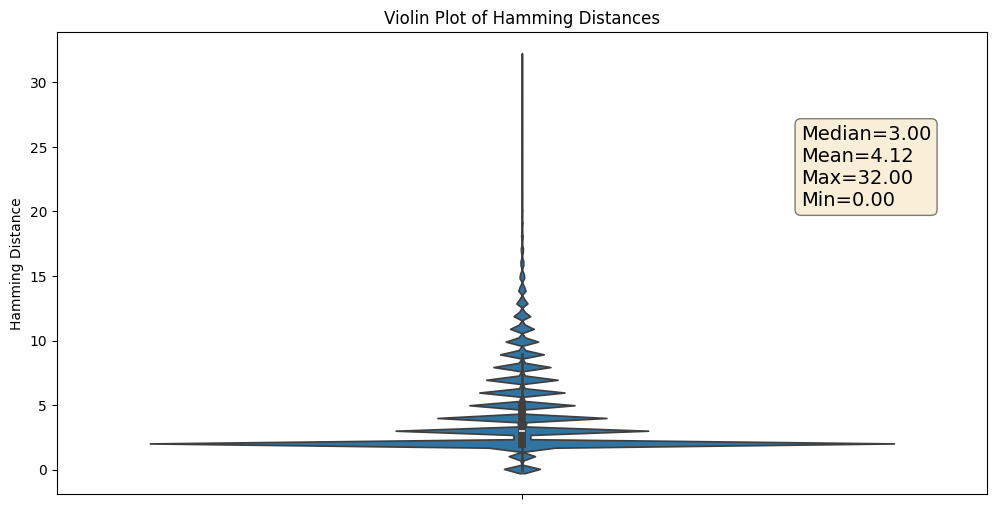

: 

In [39]:
# Plot violin plot of the Hamming distances
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.violinplot(distances)
plt.title("Violin Plot of Hamming Distances")
plt.ylabel("Hamming Distance")

# Add textbox for median, mean, max, and min on the top right corner
median = np.median(distances)
mean = np.mean(distances)
max_val = np.max(distances)
min_val = np.min(distances)

textstr = '\n'.join((
    r'Median=%.2f' % (median,),
    r'Mean=%.2f' % (mean,),
    r'Max=%.2f' % (max_val,),
    r'Min=%.2f' % (min_val,)))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0.8, 0.8, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

plt.show()
